In [38]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import rcParams
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
%matplotlib inline
import math

In [39]:
from trnasimtools.serialize import SerializeTwoCodonMultiTranscript
import os

In [40]:
def read_sim(path_pref, seed_start=1, seed_end=3, seed_incr=1, time_limit=None):
    """ 
    Reads in output for an arbitrary number of simulation trials 
    (with different seeds) and concatenates results into a single
    dataset.
    """
    df_master = pd.read_csv(f"{path_pref}_{seed_start}.tsv", sep="\t")
    df_master["seed"] = str(seed_start)
    for i in range(seed_start+1, seed_end+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    if time_limit is not None:
        df_master = df_master[df_master.time < time_limit]
    return df_master

from bisect import bisect_left
def take_closest(myList, myNumber):
    """
    Assumes myList is sorted. Returns closest value to myNumber.

    If two numbers are equally close, return the smallest number.
    """
    pos = bisect_left(myList, myNumber)
    if pos == 0:
        return myList[0]
    if pos == len(myList):
        return myList[-1]
    before = myList[pos - 1]
    after = myList[pos]
    if after - myNumber < myNumber - before:
        return after
    else:
        return before
    
def concat_sims(path_pref, max_seed):
    df_master = pd.read_csv(f"{path_pref}_1.tsv", sep="\t")
    df_master["seed"] = str(1)
    for i in range(2, max_seed+1):
        tmp = pd.read_csv(f"{path_pref}_{i}.tsv", sep="\t")
        tmp["seed"] = str(i)
        df_master = df_master.append(tmp, ignore_index=True)
    
    return df_master
    
def get_average_protein(path, perc_good, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    #tmp = df_master.loc[df_master['time'] == time].groupby(["species"])["protein"].mean().reset_index()
    tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
    tmp["delta"] = tmp.groupby(["species"])["protein"].diff(periods=8)
    tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

def get_average_protein_no_delta(path, time, max_seed):
    df_master = concat_sims(path, max_seed)
    
    df_master["time"] = df_master["time"].apply(np.ceil)
    tmp = df_master.groupby(["time", "species"])["protein"].mean().reset_index()
    #tmp = tmp[(tmp.time == time) | (tmp.time == 50.0)]
    return tmp

In [22]:
# simulation parameters 
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 50
gfp_transcript_copy_number = [10]
ribosome_copy_number = 300
total_trna = 1500
ecol_rbs_rate = 100000.0
ribosome_binding_rates_ = [100000.0, 250000.0, 500000.0, 750000.0, 1000000.0, 2500000.0]
ribosome_binding_rates = [5000000.0, 7500000.0, 10000000.0, 25000000.0]
trna_charging_rate = 100.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.9, 0.1)]
ecol_mrna_composition = (0.7, 0.3) # Making e. coli codon usage less optimal
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 0.5
ribosome_footprint = 15

date = "jan-19-2024"

In [121]:
#ecol_mrna_composition = [(x/100, round(1 - (x/100), 2)) for x in range(1, 100)]

time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = [10]
#gfp_transcript_copy_number = [5]
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [10000.0, 50000.0, 100000.0, 250000.0, 500000.0, 750000.0, 1000000.0, 2500000.0]
trna_charging_rate = 50.0 # using lower charging rate
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.7, 0.3)
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 3 
ribosome_footprint = 15

date = "feb-19-2024-a"

In [3]:
!mkdir ../output/feb-19-2024-a
!mkdir ../yaml/feb-19-2024-a

mkdir: cannot create directory ‘../output/feb-19-2024-a’: File exists
mkdir: cannot create directory ‘../yaml/feb-19-2024-a’: File exists


In [ ]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [33]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}-3.txt", "w") as stream:
    for config in configs:
        for copy_number in gfp_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [122]:
df_master = None

for copy_number in gfp_transcript_copy_number:
    df_copy = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.7_0.3_{codons[0]}_{codons[1]}_0.7_0.3" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_copy is not None:
            df_copy = df_copy.append(df_binding, ignore_index=True)
        else:
            df_copy = df_binding
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_58633/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_58633/2029633794.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


In [123]:
df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df_master.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='protein')

df["TTT_charged"] = df["TTT_charged"] / 1750
df["ATA_charged"] = df["ATA_charged"] / 750
df["free ribosome"] = df["free ribosome"] / 500

/tmp/ipykernel_58633/338538599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate


In [124]:
rcParams['figure.figsize'] = [6, 6]

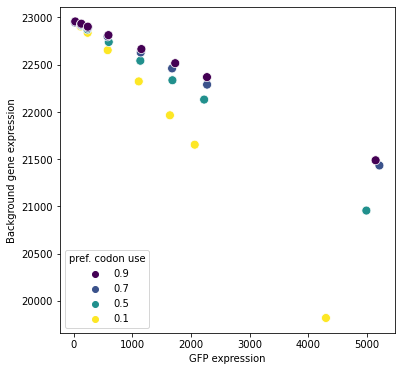

In [125]:
sns.scatterplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", s=80, palette="viridis_r")
#plt.xscale("log")
plt.xlabel("GFP expression")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="lower left")

In [126]:
df.to_csv("gfp_experiment_simulation_2.csv")

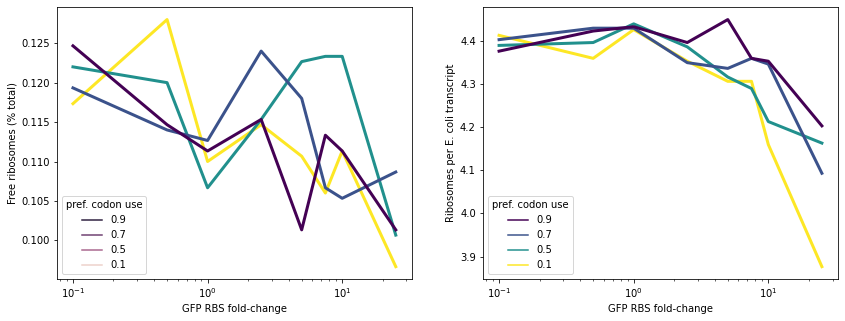

In [98]:
rcParams['figure.figsize'] = [14, 5]
fig, ax = plt.subplots(1, 2)

g1 = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "free ribosome", hue = "codon",  palette="viridis_r", linewidth=3, ax=ax[0])
g1.set_xscale("log")
g1.set_xlabel("GFP RBS fold-change")
g1.set_ylabel("Free ribosomes (% total)")
handles, labels = g.get_legend_handles_labels()
g1.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="lower left")

df_ribo = df_master[(df_master.copy_number == 10)]
df_ribo["gfp_rbs_foldx"] = df_ribo["gfp_rbs"] / ecol_rbs_rate
df_ribo = df_ribo.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='ribo_density')

g2 = sns.lineplot(data=df_ribo, x = "gfp_rbs_foldx", y = "cellularProtein", hue = "codon", linewidth=3, palette="viridis_r", ax=ax[1])
g2.set_xscale("log")
g2.set_xlabel("GFP RBS fold-change")
g2.set_ylabel("Ribosomes per E. coli transcript")
handles, labels = g2.get_legend_handles_labels()
g2.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="lower left")

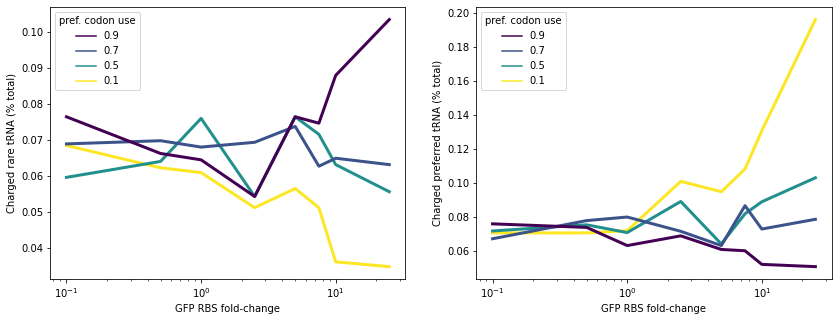

In [99]:
rcParams['figure.figsize'] = [14, 5]
fig, ax = plt.subplots(1, 2)

g1 = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "ATA_charged", hue = "codon", palette="viridis_r", linewidth=3, ax=ax[0])
g1.set_xscale("log")
g1.set_xlabel("GFP RBS fold-change")
g1.set_ylabel("Charged rare tRNA (% total)")
handles, labels = g1.get_legend_handles_labels()
g1.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="upper left")

g2 = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "TTT_charged", hue = "codon", palette="viridis_r", linewidth=3, ax=ax[1])
g2.set_xscale("log")
g2.set_xlabel("GFP RBS fold-change")
g2.set_ylabel("Charged preferred tRNA (% total)")
handles, labels = plt.gca().get_legend_handles_labels()
g2.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="upper left")

In [108]:
# Increase charging rate by order of magnitude
time_limit = 200
time_step = 5
transcript_lens = [1000, 300]
cellular_transcript_copy_number = 100
gfp_transcript_copy_number = [10]
#gfp_transcript_copy_number = [5]
ribosome_copy_number = 500
total_trna = 2500
ecol_rbs_rate = 100000.0
ribosome_binding_rates = [10000.0, 50000.0, 100000.0, 250000.0, 500000.0, 750000.0, 1000000.0, 2500000.0]
trna_charging_rate = 500.0 
transcript_names = ["cellularProtein", "GFP"]
trna_composition = [(0.7, 0.3)]
ecol_mrna_composition = (0.7, 0.3)
gfp_mrna_compositions = [(0.9, 0.1), (0.7, 0.3), (0.5, 0.5), (0.1, 0.9)]
ribosome_speed = 3 
ribosome_footprint = 15

date = "feb-20-2024"

In [105]:
!mkdir ../output/feb-20-2024
!mkdir ../yaml/feb-20-2024

mkdir: cannot create directory ‘../output/feb-20-2024’: File exists
mkdir: cannot create directory ‘../yaml/feb-20-2024’: File exists


In [109]:
for trna_prop in trna_composition:
    for comp in gfp_mrna_compositions:
        serializer = SerializeTwoCodonMultiTranscript(transcript_lens=transcript_lens,
                                                       codon_comps=[ecol_mrna_composition, comp],
                                                       trna_proportion=trna_prop,
                                                       transcript_names=transcript_names,
                                                       time_limit=time_limit,
                                                       time_step=time_step)
        serializer.serialize(f"../yaml/{date}")

In [110]:
configs = os.listdir(f"../yaml/{date}")
with open(f"../scripts/cmd_files/{date}.txt", "w") as stream:
    for config in configs:
        for copy_number in gfp_transcript_copy_number:
            for binding_rate in ribosome_binding_rates:
                for seed in range(1, 4):
                    cmd = f"python3 twocodonmultitranscript.py ../yaml/{date}/{config} {seed} {cellular_transcript_copy_number} {copy_number} " + \
                      f"{ribosome_copy_number} {total_trna} {ecol_rbs_rate} {binding_rate} {trna_charging_rate} {trna_charging_rate} " + \
                      f"../output/{date} {ribosome_speed} {ribosome_footprint}"
                    stream.write(cmd)
                    stream.write("\n")

In [111]:
df_master = None

for copy_number in gfp_transcript_copy_number:
    df_copy = None
    for binding_rate in ribosome_binding_rates:
        df_binding = None
        for codons in gfp_mrna_compositions:
            path = f"../output/{date}/two_codon_multi_transcript_0.7_0.3_{codons[0]}_{codons[1]}_0.7_0.3" + \
                   f"_{cellular_transcript_copy_number}_{copy_number}_{ribosome_copy_number}_{total_trna}" + \
                   f"_{ecol_rbs_rate}_{binding_rate}_{trna_charging_rate}_{trna_charging_rate}"
            tmp = get_average_protein(path, 0.5, 200, 3)
            tmp["codon"] = float(codons[0])
            tmp["species"] = tmp["species"].replace({"__ribosome": "free ribosome"})
            if df_binding is not None:
                df_binding = df_binding.append(tmp, ignore_index=True)
            else:
                df_binding = tmp
        df_binding["gfp_rbs"] = binding_rate
        if df_copy is not None:
            df_copy = df_copy.append(df_binding, ignore_index=True)
        else:
            df_copy = df_binding
    df_copy["copy_number"] = copy_number
    if df_master is not None:
        df_master = df_master.append(df_copy, ignore_index=True)
    else:
        df_master = df_copy

df_master = df_master[(df_master.time == 200.0)]
df_master["codon"] = df_master["codon"].div(1).round(1)

/tmp/ipykernel_58633/1584340.py:51: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  tmp = df_master.groupby(["time", "species"])["protein", "ribo_density"].mean().reset_index()
/tmp/ipykernel_58633/2029633794.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["codon"] = df_master["codon"].div(1).round(1)


In [112]:
df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate
#df = df[(df.species == "cellularProtein") | (df.species == "GFP")]
df = df_master.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='protein')

df["TTT_charged"] = df["TTT_charged"] / 1750
df["ATA_charged"] = df["ATA_charged"] / 750
df["free ribosome"] = df["free ribosome"] / 500

/tmp/ipykernel_58633/338538599.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_master["gfp_rbs_foldx"] = df_master["gfp_rbs"] / ecol_rbs_rate


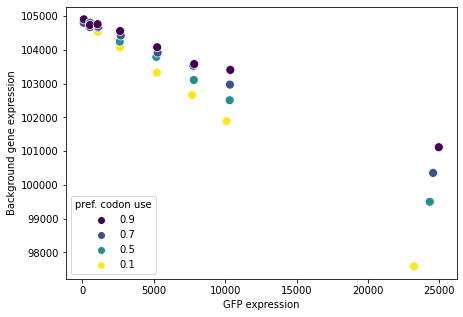

In [113]:
rcParams['figure.figsize'] = [7, 5]
sns.scatterplot(data=df, x = "GFP", y = "cellularProtein", hue = "codon", s=80, palette="viridis_r")
#plt.xscale("log")
plt.xlabel("GFP expression")
plt.ylabel("Background gene expression")
#plt.legend(title="Fraction preferred\ncodons (transgene)")
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="lower left")

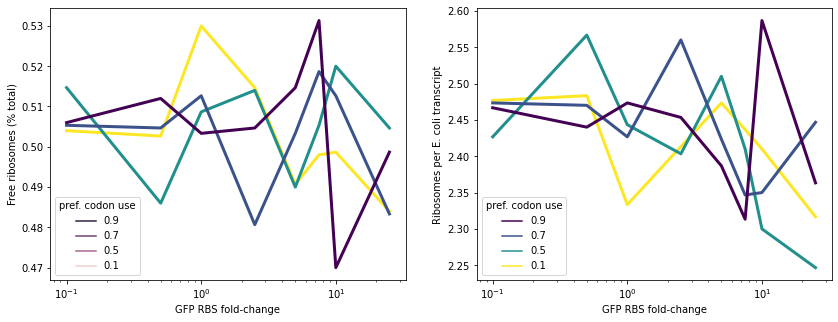

In [114]:
rcParams['figure.figsize'] = [14, 5]
fig, ax = plt.subplots(1, 2)

g1 = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "free ribosome", hue = "codon",  palette="viridis_r", linewidth=3, ax=ax[0])
g1.set_xscale("log")
g1.set_xlabel("GFP RBS fold-change")
g1.set_ylabel("Free ribosomes (% total)")
handles, labels = g.get_legend_handles_labels()
g1.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="lower left")

df_ribo = df_master[(df_master.copy_number == 10)]
df_ribo["gfp_rbs_foldx"] = df_ribo["gfp_rbs"] / ecol_rbs_rate
df_ribo = df_ribo.pivot_table(index=['gfp_rbs_foldx', 'codon'], columns='species', values='ribo_density')

g2 = sns.lineplot(data=df_ribo, x = "gfp_rbs_foldx", y = "cellularProtein", hue = "codon", linewidth=3, palette="viridis_r", ax=ax[1])
g2.set_xscale("log")
g2.set_xlabel("GFP RBS fold-change")
g2.set_ylabel("Ribosomes per E. coli transcript")
handles, labels = g2.get_legend_handles_labels()
g2.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="lower left")

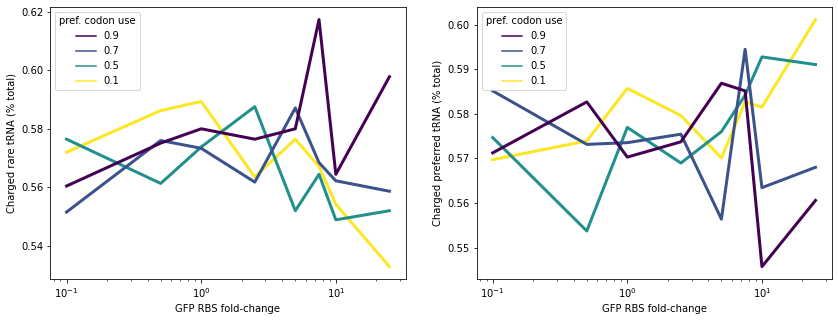

In [115]:
rcParams['figure.figsize'] = [14, 5]
fig, ax = plt.subplots(1, 2)

g1 = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "ATA_charged", hue = "codon", palette="viridis_r", linewidth=3, ax=ax[0])
g1.set_xscale("log")
g1.set_xlabel("GFP RBS fold-change")
g1.set_ylabel("Charged rare tRNA (% total)")
handles, labels = g1.get_legend_handles_labels()
g1.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="upper left")

g2 = sns.lineplot(data=df, x = "gfp_rbs_foldx", y = "TTT_charged", hue = "codon", palette="viridis_r", linewidth=3, ax=ax[1])
g2.set_xscale("log")
g2.set_xlabel("GFP RBS fold-change")
g2.set_ylabel("Charged preferred tRNA (% total)")
handles, labels = plt.gca().get_legend_handles_labels()
g2.legend(reversed(handles), reversed(labels), title="pref. codon use", loc="upper left")